In [1]:
# Import dependencies

import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from IPython.display import clear_output
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
# Set seeds

seed = 777

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

In [3]:
# Load MNIST dataset

original_dataset = datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transforms.ToTensor()
)

original_dataloader = DataLoader(original_dataset, batch_size=len(original_dataset), shuffle=False)
data = next(iter(original_dataloader))[0]

# Compute mean, std to normalize
mean = torch.mean(data)
std = torch.std(data)

minimum_value = torch.min(data)
maximum_value = torch.max(data)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean.item(), std.item())
    ]
)

# Normalize
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


In [4]:
# Check values

minimum_value, maximum_value, mean, std

(tensor(0.), tensor(1.), tensor(0.1307), tensor(0.3081))

In [5]:
# Set device

DEVICE = "cpu"
if torch.cuda.is_available():
    DEVICE = "cuda"

In [6]:
# Define autoencoder

class ConditionalAutoencoder(nn.Module):
    
    # MNIST dataset has 10 classes from 0 to 9
    num_classes = 10
    
    def __init__(self, embedding_dim: int = 64):
        super().__init__()
        
        self.embedding = nn.Embedding(self.num_classes, embedding_dim)
        
        # Encoder with embedding vector indicating a class
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28 + embedding_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 12),
            nn.ReLU(inplace=True),
            nn.Linear(12, 3)
        )
        
        # Decoder with skip connection for the embedding vector
        self.decoder = nn.Sequential(
            nn.Linear(3 + embedding_dim, 12),
            nn.ReLU(inplace=True),
            nn.Linear(12, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor, labels: torch.Tensor):
        x = x.reshape(-1, 28 * 28)
        embedded_labels = self.embedding(labels)
        
        # Encoding
        encoded_input = torch.cat([x, embedded_labels], dim=1)
        encoded = self.encoder(encoded_input)
        
        # Decoding
        decoded_input = torch.cat([encoded, embedded_labels], dim=1)
        decoded = self.decoder(decoded_input)
        
        return decoded.reshape(-1, 1, 28, 28)

In [7]:
# Define trainer

class ConditionalAutoencoderTrainer:
    def __init__(
        self, 
        autoencoder: ConditionalAutoencoder, 
        loss_function: nn.Module, 
        optimizer: optim.Optimizer, 
        epochs: int, 
        dataset: Dataset,
        dataloader: DataLoader
    ):
        self.autoencoder = autoencoder
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.epochs = epochs
        self.dataset = dataset
        self.dataloader = dataloader
        
    def fit(self) -> None:
        """Main func to train autoencoder
        """
        
        self.autoencoder.train()
        self.autoencoder.to(DEVICE)

        for epoch in range(1, self.epochs + 1):
            train_loss = []
            for data, labels in self.dataloader:
                data, labels = data.to(DEVICE), labels.to(DEVICE)
                                
                generated = self.autoencoder(data, labels)
                loss = self.loss_function(generated, data)
                train_loss += [loss.item()] 
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
            clear_output(wait=True)
            self.evaluate(epoch, sum(train_loss) / len(train_loss))
            
        self.autoencoder.eval()
    
    @torch.no_grad
    def evaluate(self, epoch: int, avg_train_loss: float) -> None:
        """Evaluate autoencoder qualitatively by visualizing
        """
        
        self.autoencoder.eval()
        
        original_images = []
        generated_images = []
        
        random_indices = torch.randint(low=0, high=len(dataset), size=(10,))
        randomly_selected = [dataset[i] for i in random_indices]
        
        for original_image, digit in randomly_selected:
            original_images.append(original_image)
            
            # Generate img with noise and embedding vector
            noise = torch.randn(1, 28 * 28).to(DEVICE) * std + mean
            label = torch.tensor([digit]).to(DEVICE)
            
            generated = self.autoencoder(noise, label)
            generated_images.append(generated.cpu())

        axes = plt.subplots(2, 10, figsize=(20, 4))[1].flatten()
        
        plt.suptitle(
            f"Epoch: {epoch}/{self.epochs}, Average train loss: {avg_train_loss} \n",
        )
        
        for axi, ax in enumerate(axes[:10]):
            ax.imshow(original_images[axi].squeeze(), cmap="gray")
            ax.set_title(f"original {randomly_selected[axi][1]}")
            ax.axis("off")
        
        for axi, ax in enumerate(axes[10:]):
            ax.imshow(generated_images[axi].squeeze(), cmap="gray")
            ax.set_title(f"generated {randomly_selected[axi][1]}")
            ax.axis("off")
        
        plt.tight_layout()
        plt.show()
        
        self.autoencoder.train()

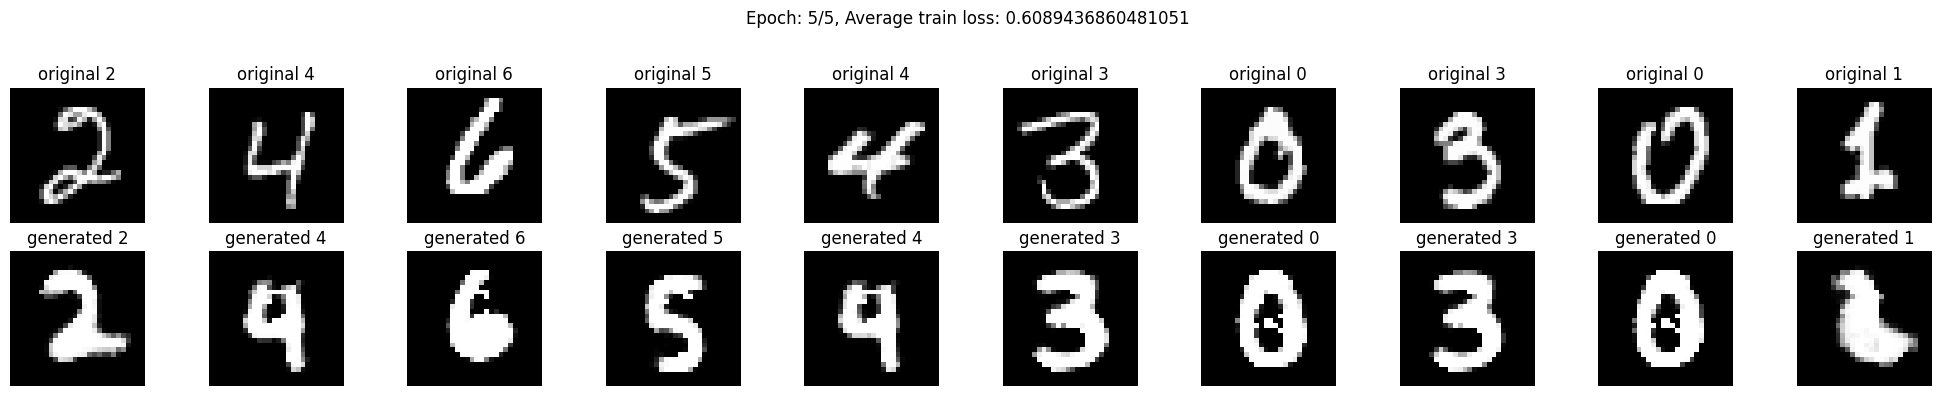

In [8]:
# Train

autoencoder = ConditionalAutoencoder()
loss_function = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

autoencoder_trainer = ConditionalAutoencoderTrainer(
    autoencoder=autoencoder, 
    loss_function=loss_function, 
    optimizer=optimizer, 
    epochs=5,
    dataset=dataset,
    dataloader=dataloader,
)

autoencoder_trainer.fit()